In [1]:
import matplotlib.pyplot as plt
import tensorflow as tf
from google.colab import drive
import numpy as np
import pandas as pd
import cv2
import random
import os

In [2]:
# drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !unzip drive/MyDrive/train.zip

Archive:  drive/MyDrive/train.zip
   creating: train/
  inflating: train/sample_12.tif     
  inflating: train/sample_12.shx     
  inflating: train/sample_12.shp     
  inflating: train/sample_12.prj     
  inflating: train/sample_12.dbf     
  inflating: train/sample_11.tif     
  inflating: train/sample_11.shx     
  inflating: train/sample_11.shp     
  inflating: train/sample_11.prj     
  inflating: train/sample_11.dbf     
  inflating: train/sample_2.tif      
  inflating: train/sample_2.shx      
  inflating: train/sample_2.shp      
  inflating: train/sample_2.prj      
  inflating: train/sample_2.dbf      
  inflating: train/sample_10.tif     
  inflating: train/sample_10.shx     
  inflating: train/sample_10.shp     
  inflating: train/sample_10.prj     
  inflating: train/sample_10.dbf     
  inflating: train/sample_9.tif      
  inflating: train/sample_9.shx      
  inflating: train/sample_9.shp      
  inflating: train/sample_9.prj      
  inflating: train/sample_9.dbf   

In [4]:
!pip install rasterio
from typing import List, Any, Tuple

import numpy as np
import geopandas as gpd

import rasterio
from rasterio import mask
from rasterio.io import MemoryFile
from rasterio.windows import transform, Window
from rasterio.features import dataset_features

from skimage import exposure
from rasterio.plot import show
import matplotlib.pyplot as plt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 58.9 MB/s eta 0:00:00


{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 767, 'height': 668, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.388124855798503e-05, 0.0, 47.50594338782057,
       0.0, -1.3878893913765135e-05, 41.090411991945984), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


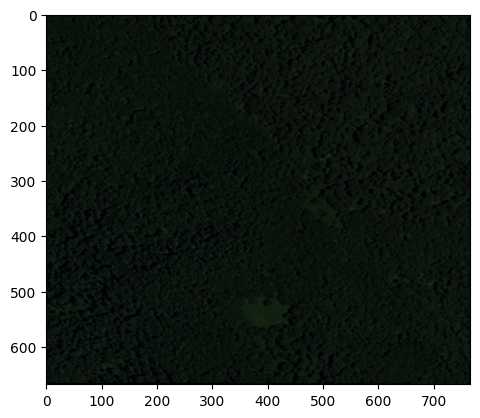

In [5]:
raster_file_path = "/content/train/sample_1.tif"
with rasterio.open(raster_file_path, mode = "r") as src:
  print(src.profile)
  img = (src.read([1, 2, 3]).transpose([1, 2, 0])/4095 * 255).astype(int)
  plt.imshow(img)


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


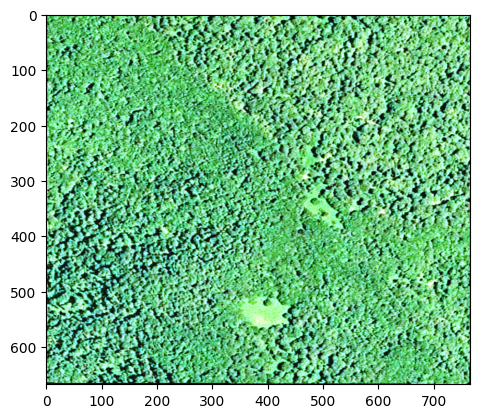

In [6]:
img_adapteq = exposure.equalize_hist(img)
plt.imshow(img_adapteq)

In [7]:
def read_vector_file(shp_path):
  return gpd.read_file(shp_path, mode = "r")

In [8]:
vector_file_path = "/content/train/sample_1.shp"
vector_file = read_vector_file(vector_file_path)
vector_file

,id,geometry
0,None,"POLYGON ((47.50597 41.09041, 47.51659 41.09038..."


In [9]:
vector_file.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   id        0 non-null      object  
 1   geometry  1 non-null      geometry
dtypes: geometry(1), object(1)
memory usage: 144.0+ bytes


In [10]:
def convert_vector_to_array(vectorfile: gpd.GeoDataFrame) -> np.ndarray:
  return np.array(vectorfile["geometry"].values)

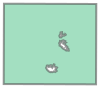

In [11]:
geometry_objects = convert_vector_to_array(vector_file)
geometry_objects[0]

In [12]:
def mask_raster(raster: rasterio.io.DatasetReader, geometry_objects: np.ndarray) -> Tuple[Any, Any]:
  return mask.raster_geometry_mask(raster, geometry_objects, invert = True)


In [13]:
binary_mask, _, _ = mask_raster(src, geometry_objects)

In [14]:
print(binary_mask.shape)
binary_mask[0:100, 700:800]

(668, 767)


array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [15]:
!pip install patchify

In [16]:
# Changed patch_size from 256 to 64
from patchify import patchify
import os
import cv2
from PIL import Image
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
train_dataset_path = "/content/train/"
patch_size = 64
image_dataset = []

filenames = os.listdir(train_dataset_path)
for file in filenames:
  if file.endswith(".tif"):
    image = cv2.imread(train_dataset_path + file, 1)
    SIZE_X = (image.shape[1]//patch_size)*patch_size
    SIZE_Y = (image.shape[0]//patch_size)*patch_size
    image = Image.fromarray(image)
    image = image.crop((0, 0, SIZE_X, SIZE_Y))
    image = np.array(image)
    print("Patchifying image", train_dataset_path + file)
    patches_img = patchify(image, (patch_size, patch_size, 3), step = patch_size)

    for i in range(patches_img.shape[0]):
      for j in range(patches_img.shape[1]):
        single_patch_img = patches_img[i, j, :, :]
        single_patch_img = scaler.fit_transform(single_patch_img.reshape(-1, single_patch_img.shape[-1])).reshape(single_patch_img.shape)
        single_patch_img = single_patch_img[0]
        image_dataset.append(single_patch_img)
len(image_dataset[0])

Patchifying image /content/train/sample_20.tif
Patchifying image /content/train/sample_9.tif
Patchifying image /content/train/sample_3.tif
Patchifying image /content/train/sample_19.tif
Patchifying image /content/train/sample_6.tif
Patchifying image /content/train/sample_11.tif
Patchifying image /content/train/sample_13.tif
Patchifying image /content/train/sample_8.tif
Patchifying image /content/train/sample_10.tif
Patchifying image /content/train/sample_2.tif
Patchifying image /content/train/sample_16.tif
Patchifying image /content/train/sample_14.tif
Patchifying image /content/train/sample_1.tif
Patchifying image /content/train/sample_5.tif
Patchifying image /content/train/sample_15.tif
Patchifying image /content/train/sample_4.tif
Patchifying image /content/train/sample_17.tif
Patchifying image /content/train/sample_18.tif
Patchifying image /content/train/sample_12.tif
Patchifying image /content/train/sample_7.tif


64

In [17]:
image_dataset[0].shape

(64, 64, 3)

In [18]:
mask_dataset = []
for file in filenames:
  if file.endswith((".tif")):
    image_name = file
    shapefile = file.split('.')[0] + ".shp"
    vector_file = read_vector_file(train_dataset_path + shapefile)
    geometry_objects = convert_vector_to_array(vector_file)
    with rasterio.open(train_dataset_path + image_name, mode = "r") as src:
      img = (src.read([1, 2, 3]).transpose([1, 2, 0])/4095 * 255).astype(int)
    binary_mask, _, _ = mask_raster(src, geometry_objects)
    SIZE_X = (binary_mask.shape[1]//patch_size) * patch_size
    SIZE_Y = (binary_mask.shape[0]//patch_size) * patch_size
    binary_mask = Image.fromarray(binary_mask)
    binary_mask.crop((0, 0, SIZE_X, SIZE_Y))
    binary_mask = np.array(binary_mask)
    print("Patchifiying mask:" + train_dataset_path + shapefile)

    patches_mask = patchify(binary_mask, (patch_size, patch_size), step = patch_size)

    for i in range(patches_mask.shape[0]):
      for j in range(patches_mask.shape[1]):
        single_patch_mask = patches_mask[i, j, :, :]
        mask_dataset.append(single_patch_mask)

Patchifiying mask:/content/train/sample_20.shp
Patchifiying mask:/content/train/sample_9.shp
Patchifiying mask:/content/train/sample_3.shp
Patchifiying mask:/content/train/sample_19.shp
Patchifiying mask:/content/train/sample_6.shp
Patchifiying mask:/content/train/sample_11.shp
Patchifiying mask:/content/train/sample_13.shp
Patchifiying mask:/content/train/sample_8.shp
Patchifiying mask:/content/train/sample_10.shp
Patchifiying mask:/content/train/sample_2.shp
Patchifiying mask:/content/train/sample_16.shp
Patchifiying mask:/content/train/sample_14.shp
Patchifiying mask:/content/train/sample_1.shp
Patchifiying mask:/content/train/sample_5.shp
Patchifiying mask:/content/train/sample_15.shp
Patchifiying mask:/content/train/sample_4.shp
Patchifiying mask:/content/train/sample_17.shp
Patchifiying mask:/content/train/sample_18.shp
Patchifiying mask:/content/train/sample_12.shp
Patchifiying mask:/content/train/sample_7.shp


In [23]:
image_dataset = np.array(image_dataset)
mask_dataset =  np.array(mask_dataset)

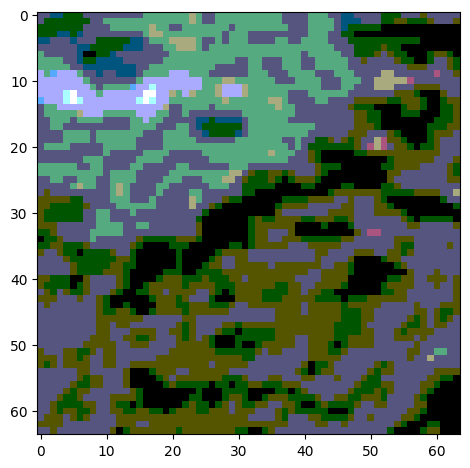

In [154]:
import random
import numpy as np
image_number = random.randint(0, len(image_dataset))
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(image_dataset[300], (patch_size, patch_size, 3)))




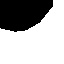

In [155]:
Image.fromarray(mask_dataset[300])

In [28]:
mask_dataset_expanded = np.expand_dims(mask_dataset, axis = 3)
mask_dataset_expanded.shape

(3837, 64, 64, 1)

In [31]:
np.max(mask_dataset_expanded)

True

In [32]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset_expanded, test_size = 0.2, random_state = 42)

In [36]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras.layers import Activation, MaxPool2D, Concatenate
from keras.optimizers import Adam

def conv_block(input, num_filters):
  x = Conv2D(num_filters, 3, padding = "same")(input)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)

  x = Conv2D(num_filters, 3, padding = "same")(x)
  x = BatchNormalization()(x)
  x = Activation("relu")(x)
  return x

def encoder_block(input, num_filters):
  x = conv_block(input, num_filters)
  p = MaxPool2D((2, 2))(x)
  return x, p

def decoder_block(input, skip_features, num_filters):
  x = Conv2DTranspose(num_filters, (2, 2), strides = 2, padding = "same")(input)
  x = Concatenate()([x, skip_features])
  x = conv_block(x, num_filters)
  return x

def build_unet(input_shape, n_classes):
  inputs = Input(input_shape)

  s1, p1 = encoder_block(inputs, 64)
  s2, p2 = encoder_block(p1, 128)
  s3, p3 = encoder_block(p2, 256)
  s4, p4 = encoder_block(p3, 512)

  b1 = conv_block(p4, 1024) #Bridge

  d1 = decoder_block(b1, s4, 512)
  d2 = decoder_block(d1, s3, 256)
  d3 = decoder_block(d2, s2, 128)
  d4 = decoder_block(d3, s1, 64)

  if n_classes == 1:  #Binary
    activation = 'sigmoid'
  else:
    activation = 'softmax'

  outputs = Conv2D(n_classes, 1, padding="same", activation=activation)(d4)  #Change the activation based on n_classes
  print(activation)

  model = Model(inputs, outputs, name="U-Net")
  return model




In [37]:
IMG_HEIGHT = image_dataset.shape[1]
IMG_WIDTH = image_dataset.shape[2]
IMG_CHANNELS = image_dataset.shape[3]
input_shape = (IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)

In [38]:
model = build_unet(input_shape, n_classes = 1)
model.compile(optimizer = Adam(learning_rate = 1e-3), loss = "binary_crossentropy", metrics = ["accuracy"])
model.summary()

sigmoid
Model: "U-Net"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 64, 64, 3)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 64, 64, 64)           1792      ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 64, 64, 64)           256       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 64, 64, 64)           0         ['batch_normalizat

In [39]:
history_1 = model.fit(X_train, y_train,
                      batch_size = 16,
                      verbose = 1,
                      epochs = 25,
                      validation_data = (X_test, y_test),
                      shuffle = False)

Epoch 1/25
192/192 [==============================] - 56s 119ms/step - loss: 0.2576 - accuracy: 0.9002 - val_loss: 4.7000 - val_accuracy: 0.3375
Epoch 2/25
192/192 [==============================] - 17s 90ms/step - loss: 0.1662 - accuracy: 0.9419 - val_loss: 0.1674 - val_accuracy: 0.9362
Epoch 3/25
192/192 [==============================] - 17s 91ms/step - loss: 0.1388 - accuracy: 0.9528 - val_loss: 0.1987 - val_accuracy: 0.9474
Epoch 4/25
192/192 [==============================] - 18s 94ms/step - loss: 0.1095 - accuracy: 0.9635 - val_loss: 0.1496 - val_accuracy: 0.9439
Epoch 5/25
192/192 [==============================] - 18s 94ms/step - loss: 0.0976 - accuracy: 0.9665 - val_loss: 0.0969 - val_accuracy: 0.9660
Epoch 6/25
192/192 [==============================] - 18s 93ms/step - loss: 0.0906 - accuracy: 0.9684 - val_loss: 0.0899 - val_accuracy: 0.9693
Epoch 7/25
192/192 [==============================] - 18s 93ms/step - loss: 0.0853 - accuracy: 0.9710 - val_loss: 0.0996 - val_accuracy

In [40]:
model.evaluate(X_test, y_test)

24/24 [==============================] - 4s 41ms/step - loss: 0.0672 - accuracy: 0.9766


[0.06717924028635025, 0.9766333699226379]

In [41]:
unique_values = np.unique(mask_dataset)
print(unique_values)

[False  True]


In [42]:
mask_dataset_with_0_1 = mask_dataset_expanded
mask_dataset_with_0_1[mask_dataset_with_0_1 == False] = 0
np.unique(mask_dataset_with_0_1)

array([False,  True])

In [99]:
test_image_tiles = []
test_image = cv2.imread("/content/test.tif", 1)
SIZE_X_test = (test_image.shape[1]//patch_size)*patch_size
SIZE_Y_test = (test_image.shape[0]//patch_size)*patch_size
test_image = Image.fromarray(test_image)
test_image = test_image.crop((0, 0, SIZE_X_test, SIZE_Y_test))
test_image_not_array = test_image
test_image = np.array(test_image)
print("Patchified image")
patches_test_img = patchify(test_image, (patch_size, patch_size, 3), step = patch_size)
for i in range(patches_test_img.shape[0]):
  for j in range(patches_test_img.shape[1]):
    single_patch_test_img = patches_test_img[i, j, :, :]
    single_patch_test_img = scaler.fit_transform(single_patch_test_img.reshape(-1, single_patch_test_img.shape[-1])).reshape(single_patch_test_img.shape)
    single_patch_test_img = single_patch_test_img[0]
    test_image_tiles.append(single_patch_test_img)

Patchified image


In [111]:
test_image_tiles = np.array(test_image_tiles)
test_image_tiles.shape

(91, 64, 64, 3)

In [80]:
predicted_output = model.predict(test_image_tiles)

3/3 [==============================] - 3s 1s/step


In [135]:
predicted_output_argmax = np.round(predicted_output)

In [86]:
image = Image.fromarray(test_image.astype('uint8'))

# Specify the directory and filename where you want to save the image
directory = '/content'
filename = 'cropped_image.tif'

# Combine the directory and filename to create the full path
full_path = f'{directory}/{filename}'

# Save the image to the specified directory
image.save(full_path)

{'driver': 'GTiff', 'dtype': 'uint16', 'nodata': None, 'width': 892, 'height': 471, 'count': 4, 'crs': CRS.from_epsg(4326), 'transform': Affine(1.388888888888889e-05, 0.0, 47.625402777777786,
       0.0, -1.388888888888889e-05, 41.137388888888886), 'blockysize': 1, 'tiled': False, 'interleave': 'pixel'}


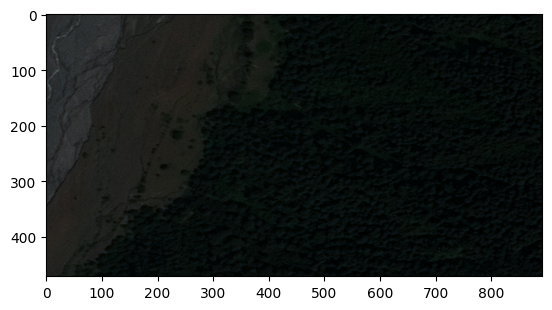

In [174]:
raster_file_path = "/content/test.tif"
with rasterio.open(raster_file_path, mode = "r") as src:
  print(src.profile)
  img = (src.read([1, 2, 3]).transpose([1, 2, 0])/4095 * 255).astype(int)
  plt.imshow(img)


/usr/local/lib/python3.10/dist-packages/skimage/_shared/utils.py:394: UserWarning: This might be a color image. The histogram will be computed on the flattened image. You can instead apply this function to each color channel, or set channel_axis.
  return func(*args, **kwargs)


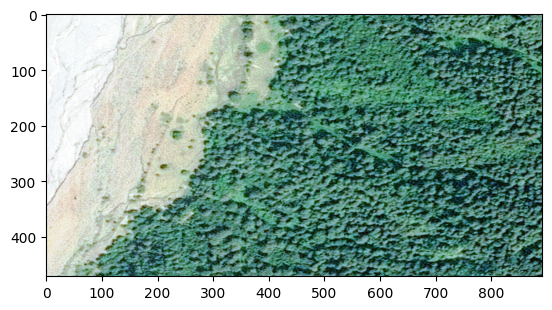

In [175]:
img_adapteq = exposure.equalize_hist(img)
plt.imshow(img_adapteq)

In [142]:
predicted_output_reshaped = np.expand_dims(predicted_output_argmax.reshape(((7, 13, 64, 64, 1))), axis = 2)

In [143]:
print(predicted_output_reshaped.shape), print(predicted_output.shape)

(7, 13, 1, 64, 64, 1)
(91, 64, 64, 1)


(None, None)

In [144]:
from patchify import unpatchify
unpatched_mask = unpatchify(predicted_output_reshaped, (448, 832, 1))

In [145]:
unpatched_mask.shape

(448, 832, 1)

In [171]:
unpatched_mask_integer = unpatched_mask.astype(int)
unpatched_mask_boolean = unpatched_mask.astype(bool)


In [210]:
unpatched_mask_integer[unpatched_mask_integer == 0] = False
unpatched_mask_integer[unpatched_mask_integer == 1] = True

In [211]:
unpatched_mask_integer.shape

(448, 832, 1)

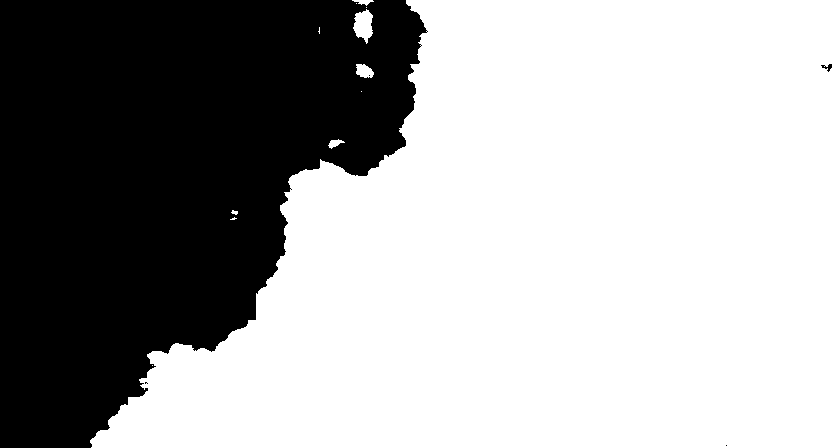

In [214]:
# This is the segmanted form of geotiff image:
Image.fromarray(unpatched_mask_boolean.squeeze())

In [205]:
#### The code for creating shapefile from raster image and binary mask in helper_scripts did not work for my code.
def convert_array_to_vector(binary_mask: np.array, img_path: str) -> gpd.GeoDataFrame:
    """Convert masked array to vector file(.shp).

    Args:
        binary_mask: Output predicted binary mask.
        img_path: Path of the raster file used for the prediction.

    Returns:
        shp: GeoPandas DataFrame.

    """
    with rasterio.open(img_path, mode='r') as src:
        mask_meta = src.meta.copy()
        mask_meta.update(
            {
                'dtype': 'uint8',
                'count': 1,
                'nodata': 0.0
            }
        )

        with MemoryFile() as memfile:
            with memfile.open(**mask_meta) as mem:
                mem.write_band(1, binary_mask)
                geoms = dataset_features(
                    mem,
                    geographic=False,
                    as_mask=True,
                    with_nodata=True
                )
                shp = gpd.GeoDataFrame.from_features(
                    geoms,
                    crs=str(mem.crs).lower(),
                    columns=['geometry', 'val']
                )
    return shp

In [206]:
unpatched_mask_boolean = unpatched_mask_boolean.squeeze()

In [207]:
unpatched_mask_boolean.shape

(448, 832)

In [213]:
# converted_vector_file = convert_array_to_vector(unpatched_mask_boolean, '/content/cropped_image.tif')


In [202]:
# def save_vector_file(shp: gpd.GeoDataFrame, dest_path: str) -> None:
#     """Write vector file to the disk.

#     Args:
#         dest_path: Destionation path to save the vector file.
#         shp: vector dataframe.

#     """
#     shp.to_file(dest_path)

In [203]:
# save_vector_file(converted_vector_file, "tmp.shp")

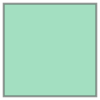